In [1]:
# model definition and training
import chainer
from PIL import Image
import numpy as np
import argparse
import glob
from time import strftime
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.backends import cuda
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions

class WLClassifier(chainer.Chain):
    def __init__(self, predictor):
        super(WLClassifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, *args):
        x = args[0]
        t = args[-1]
        self.y = None
        self.loss = None
        self.accuracy = None
        self.y = self.predictor(x)
        self.loss = self.lossfun(self.y, t)
        chainer.report({'loss': self.loss}, self)
        #print(np.sqrt(mean_squared_error(t[0][0], self.y.data[0][0])))
        return self.loss
        
    def lossfun(self, y, t):
        return F.sigmoid_cross_entropy(y,t)

class MLP(chainer.Chain):

    def __init__(self, n_units1, n_units2):
        super(MLP, self).__init__()
        with self.init_scope():
            initializer = chainer.initializers.HeNormal()
            self.l1 = L.Convolution2D(3, n_units1, 5, stride=1, pad=2, initialW=initializer)
            #self.l2 = L.Convolution2D(None, n_units2, 5, stride=1, pad=2, initialW=initializer)
            self.l3 = L.Convolution2D(None, 1, 1)
            
    def __call__(self, *args):

        #assert len(args) >= 2
        x = args[0]
        #t = args[-1]
        #t = x
        #self.y = None
        #self.loss = None
        #self.accuracy = None
        self.y = self.forward(x)
        #self.loss = self.lossfun(self.y, t)
        #chainer.report({'loss': self.loss}, self)
        #print(np.sqrt(mean_squared_error(t[0][0], self.y.data[0][0])))
        return self.y
 
    def forward(self, x):
        #print(x.data.shape)
        h1 = F.relu(self.l1(x))
        #h2 = F.relu(self.l2(h1))
        #print(h1.data.shape)
        h3 = self.l3(h1)
        return h3

    def lossfun(self, y, t):
        #return F.sigmoid_cross_entropy(y,t)
        return (y * (t - (y >= 0)) - F.log1p(F.exp(-F.abs(y))))
        #return chainer.functions.mean_squared_error(F.tanh(y), (-t*2+1).astype(np.float32))
        
   
imw = 320
imh = 240


model = MLP(4,2)
x = np.zeros((0, 3, imh, imw), dtype=np.float32)
t = np.zeros((0, 1, imh, imw), dtype=np.int32)
classifier = WLClassifier(model)

import os
jpgfiles = glob.glob('white-line2020/*.jpg')
print(jpgfiles)
for f in jpgfiles:
    img = Image.open(f).resize((imw, imh))
    plt.imshow(np.array(img))
    a = np.asarray(img).transpose(2,0,1).astype(np.float32)/255.
    a1 = np.expand_dims(a,axis=0)
    x = np.append(x, a1, axis=0)
    
    lfile = os.path.splitext(f)[0] + '_label.png'
    print(lfile)
    img = Image.open(lfile).resize((imw, imh))
    img = img.convert('L')
    a = np.asarray(img).astype(np.float32)/254.
    a = a.astype(np.int32)
    print(np.sum(a))
    a1 = np.expand_dims(a,axis=0)
    a1 = np.expand_dims(a1,axis=0)
    t = np.append(t, a1, axis=0)

optimizer = chainer.optimizers.Adam()
optimizer.setup(classifier)
model.to_gpu()

for rep in range(20):
    train = chainer.datasets.TupleDataset(x, t)
    train_iter = chainer.iterators.SerialIterator(train, 4)
    #test_iter = chainer.iterators.SerialIterator(test, 1, repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=0)
    trainer = training.Trainer(updater, (500, 'epoch'), out='test1')

    # Evaluate the model with the test dataset for each epoch
    #trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    # trainer.extend(extensions.dump_graph('main/loss'))

    # Write a log of evaluation statistics for each epoch
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    # Print a progress bar to stdout
    #trainer.extend(extensions.ProgressBar())
    trainer.run()
    
    
chainer.serializers.save_npz('model_' + strftime("%Y%m%d_%H%M%S") + '.npz', model)

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


['white-line2020/000225.jpg', 'white-line2020/000252.jpg', 'white-line2020/000211.jpg', 'white-line2020/000215.jpg', 'white-line2020/000267.jpg', 'white-line2020/000296.jpg', 'white-line2020/000206.jpg', 'white-line2020/000268.jpg', 'white-line2020/000259.jpg', 'white-line2020/000216.jpg', 'white-line2020/000266.jpg', 'white-line2020/000247.jpg', 'white-line2020/000312.jpg', 'white-line2020/000208.jpg', 'white-line2020/000281.jpg', 'white-line2020/000276.jpg', 'white-line2020/000222.jpg', 'white-line2020/000315.jpg', 'white-line2020/000284.jpg', 'white-line2020/000235.jpg', 'white-line2020/000314.jpg', 'white-line2020/000228.jpg', 'white-line2020/000227.jpg', 'white-line2020/000254.jpg', 'white-line2020/000295.jpg', 'white-line2020/000292.jpg', 'white-line2020/000280.jpg', 'white-line2020/000318.jpg', 'white-line2020/000230.jpg', 'white-line2020/000207.jpg', 'white-line2020/000264.jpg', 'white-line2020/000313.jpg', 'white-line2020/000226.jpg', 'white-line2020/000316.jpg', 'white-line20

14          0.222351                                                                   1.90949       
15          0.219232                                                                   2.01157       
16          0.218802                                                                   2.10989       
17          0.21751                                                                    2.21203       
18          0.217927                                                                   2.31418       
19          0.218159                                                                   2.41633       
20          0.212395                                                                   2.51466       
21          0.214505                                                                   2.61692       
22          0.215417                                                                   2.71915       
23          0.21095                                                               

93          0.130356                                                                   9.93069       
94          0.128317                                                                   10.0336       
95          0.129076                                                                   10.1365       
96          0.127532                                                                   10.2355       
97          0.127095                                                                   10.3384       
98          0.126534                                                                   10.4413       
99          0.124846                                                                   10.5443       
100         0.125286                                                                   10.6434       
101         0.124852                                                                   10.7464       
102         0.123095                                                              

172         0.0915169                                                                  18.0109       
173         0.0910679                                                                  18.1145       
174         0.0905688                                                                  18.218        
175         0.0917377                                                                  18.3216       
176         0.0898248                                                                  18.4215       
177         0.090566                                                                   18.5251       
178         0.0901562                                                                  18.6287       
179         0.0899281                                                                  18.7324       
180         0.0907068                                                                  18.8322       
181         0.0901056                                                             

251         0.085548                                                                   26.1476       
252         0.0847517                                                                  26.2481       
253         0.0852926                                                                  26.3523       
254         0.0851185                                                                  26.4566       
255         0.0848509                                                                  26.561        
256         0.0854774                                                                  26.6613       
257         0.0848054                                                                  26.7656       
258         0.0859323                                                                  26.8697       
259         0.0839056                                                                  26.9741       
260         0.0854139                                                             

330         0.0830897                                                                  34.3333       
331         0.0829277                                                                  34.4383       
332         0.0828953                                                                  34.5394       
333         0.0830399                                                                  34.6443       
334         0.0823952                                                                  34.7492       
335         0.0827427                                                                  34.8542       
336         0.0828167                                                                  34.9554       
337         0.0827436                                                                  35.0605       
338         0.0823088                                                                  35.1655       
339         0.0829127                                                             

KeyboardInterrupt: 

In [2]:
import numpy as np
def eval_image(fname, thre):
    model.to_cpu()
    testx = np.zeros((0, 3, imh, imw), dtype = np.float32)

    y2 = cuda.to_cpu(model.y.data)
    #plt.imshow(y2[0][0])
    img = Image.open(fname).convert('RGB').resize((imw,imh))
    a = np.asarray(img).transpose(2,0,1).astype(np.float32)/255.
    a1 = np.expand_dims(a,axis=0)
    #print(a1.shape)
    testx = np.append(testx, a1, axis=0)

    import time
    t0 = time.time()
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        testy = model.forward(testx)
    print('forward time [s]: ' + str(time.time()-t0))

    #fig, axs = plt.subplots(1,3)
    #plt.imshow(img, ax=axs[0])
    imd = Image.new('RGB', (imw*2, imh))
    imd.paste(img)
    thimg = (testy.data[0][0]> thre)
    thimg = thimg.astype(np.uint8) * 255

    thimg = Image.fromarray(thimg, 'L')
    plt.imshow(thimg)

    imd.paste(thimg, (imw, 0))
    plt.imshow(imd)
    return testy.data[0][0]



forward time [s]: 0.018691301345825195


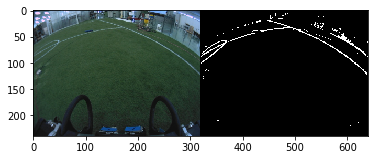

In [3]:
chainer.serializers.load_npz("model_20200107_070457.npz", model)
a = eval_image('white-line2020/000206.jpg', 0)

In [ ]:
a = eval_image('000003.jpg', 0)

In [ ]:
a = eval_image('000013.jpg', 0)

In [ ]:
a = eval_image('000047.jpg', 0)

In [ ]:
a = eval_image('000034.jpg', 0)